## **Задание 4:**
1. Собрать собственный датасет для детектирования объектов.
2. Реализовать детектирование методом сканирующего окна с HOG дескриптором.
3. Реализовать детектирование объектов по собранному датасету с помощью тюнинга Yolo.
4. Сравнить эффективность полученных детекторов, используя метрики качества детектирования объектов.

In [ ]:
# монтируем google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install --q imutils
!pip install mean_average_precision

In [ ]:
import cv2
from glob import glob
import imutils
import numpy as np
import os
import torch
from PIL import Image
from numpy.linalg import norm
from collections import defaultdict
from skimage.feature import hog
from mean_average_precision import MetricBuilder

In [ ]:
def sliding_window(image, step, ws):
    #slide a window of ws size over the image
    for y in range(0, image.shape[0]-ws[1], step): # rows-wise loop
        # -ws[1] avoids extending the sliding window outside the image itself, increment the y-position with step
        for x in range(0, image.shape[1] - ws[0], step):#columns-wise loop, increment the x-position with step
            # use yield(instead of return) because this is a generator
            #yield the actual x and y positions and the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])


def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [ ]:
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16*3 # running on laptop so I generated a small pyramid
ROI_SIZE = (200, 150)
INPUT_SIZE = (224, 224)
NC = 20

Извлечение регионов интереса (ROIs) из изображения при помощи пирамиды и скользящего окна:

In [ ]:
def extract_rois_and_locations(image, roi_size=(200, 150), win_step=48, pyr_scale=1.5):
    pyramid = image_pyramid(image, scale=pyr_scale, minSize=roi_size)
    rois, locs = [], []

    for resized in pyramid:
        for (x, y, roi) in sliding_window(resized, win_step, roi_size):
            if roi.shape[0] != roi_size[1] or roi.shape[1] != roi_size[0]:
                continue
            rois.append(roi)
            locs.append((x, y, x + roi_size[0], y + roi_size[1]))

    return rois, locs

Вычисление HOG-дескриптора:

In [ ]:
def compute_hog(img):
    img = cv2.resize(img, (400, 400))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    return features

Обучение HOG-классификатора:

In [ ]:
def train_hog(train_image_paths, train_label_paths):
    class_vectors = defaultdict(list)
    for image_path, label_path in zip(train_image_paths, train_label_paths):
        image = cv2.imread(image_path)
        hog_vector = compute_hog(image)

        with open(label_path, 'r') as f:
            label = int(f.readline().strip().split(' ')[0])
            class_vectors[label].append(hog_vector)
    return class_vectors

Сравнение HOG-вектора с векторами классов, нахождение наилучшего:

In [ ]:
def get_best_label_dist(hog_vector, class_vectors):
    best_label = -1
    best_distance = float('inf')
    for label, vectors in class_vectors.items():
        distances = np.linalg.norm(np.array(vectors) - hog_vector, axis=1)
        min_distance = np.min(distances)
        if min_distance < best_distance:
            best_distance = min_distance
            best_label = label
    return best_label, best_distance

Детекция объектов на одном изображении:


In [ ]:
def detect_img(img, class_vectors, roi_size=(200, 150), win_step=48, pyr_scale=1.5):
    rois, locs = extract_rois_and_locations(img, roi_size, win_step, pyr_scale)
    best_loc = None
    best_label = -1
    best_distance = float('inf')

    for roi, loc in zip(rois, locs):
        hog_vector = compute_hog(roi)
        label, distance = get_best_label_dist(hog_vector, class_vectors)
        if distance < best_distance:
            best_distance = distance
            best_loc = loc
            best_label = label

    return best_loc, best_label

Детекция объектов на нескольких изображениях:

In [ ]:
def detect(images, class_vectors, roi_size=(200, 150), win_step=48, pyr_scale=1.5):
    results = []
    for img_path in images:
        image = cv2.imread(img_path)
        loc, label = detect_img(image, class_vectors, roi_size, win_step, pyr_scale)
        if loc is not None:
            results.append((loc, label))
    return results

In [ ]:
def get_file_paths(image_dir, label_dir, image_ext='.jpeg', label_ext='.txt'):
    image_paths = glob(os.path.join(image_dir, f"*{image_ext}"))
    label_paths = [
        os.path.join(label_dir, f"{os.path.splitext(os.path.basename(image_path))[0]}{label_ext}")
        for image_path in image_paths
    ]
    return image_paths, label_paths

In [ ]:
def parse_gt(label_paths, img_size=400):
    gt = []
    for label_path in label_paths:
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            parts = line.split(' ')
            label = int(parts[0])
            bbox = list(map(lambda x: int(float(x) * img_size), parts[1:]))
            gt.append(np.array(bbox + [label, 0, 0]))
    return np.array(gt)

In [ ]:
def format_predictions(predictions):
    formatted = []
    for pred in predictions:
        if pred is not None:
            (xmin, ymin, xmax, ymax), label = pred
            formatted.append(np.array([xmin, ymin, xmax, ymax, label, 0.5]))
    return np.array(formatted)

В качестве датасета для данной работы были выбраны изображения знаков сервиса ПДД, представленные в 20 классах, что соответствует количеству таких знаков. Перед началом обучения датасет был дополнительно аугментирован.

In [ ]:
# распакуем датасет
!unzip -qq /content/drive/MyDrive/3_сем/CV/Task4/dataset_2.zip

Пути к директориям:

In [ ]:
BASE_DIR = '/content/dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'valid')

train_image_paths, train_label_paths = get_file_paths(os.path.join(TRAIN_DIR, 'images'), os.path.join(TRAIN_DIR, 'labels'))
val_image_paths, val_label_paths = get_file_paths(os.path.join(VAL_DIR, 'images'), os.path.join(VAL_DIR, 'labels'))

Обучение, детекция объектов на валидации:

In [ ]:
class_vectors = train_hog(train_image_paths, train_label_paths)
predictions = detect(val_image_paths, class_vectors)
gt = parse_gt(val_label_paths)
preds = format_predictions(predictions)

Расчет mAP:

In [ ]:
mAP = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=NC)
mAP.add(gt, preds)
print(f"mAP: {mAP.value(iou_thresholds=0.2)['mAP']}")

mAP: 0.0


###YOLO

In [ ]:
import yaml

data_content = {
    'train': '/content/dataset/train/images',
    'val': '/content/dataset/valid/images',
    'nc': 20,
    'names': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
}

yaml_path = '/content/data.yaml'

with open(yaml_path, 'w') as file:
    yaml.dump(data_content, file, default_flow_style=False, allow_unicode=True)

print(f"data.yaml has been rewritten at {yaml_path}")

data.yaml has been rewritten at /content/data.yaml


In [ ]:
# склонируем репозиторий с yolov5 и установим необходимые пакеты
!git clone https://github.com/ultralytics/yolov5
%cd /content/yolov5
!pip install -r requirements.txt
!mv /content/data.yaml /content/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17075, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 17075 (delta 27), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17075/17075), 15.68 MiB | 18.44 MiB/s, done.
Resolving deltas: 100% (11717/11717), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 26.5 MB/s eta 0:00:00


In [ ]:
# train
!python /content/yolov5/train.py --img 640 --batch-size 16 --epoch 50 --data '/content/data.yaml' --weights yolov5s.pt --patience 15

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-09 21:11:37.095858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 21:11:37.127399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 21:11:37.141850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

In [ ]:
# запустим прогон на тестовой выборке
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.1 --source /content/dataset/test

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/dataset/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs
image 1/5 /content/dataset/test/image_1.jpg: 640x576 1 2, 1 5, 29.7ms
image 2/5 /content/dataset/test/image_2.jpg: 640x640 1 1, 11.7ms
image 3/5 /content/dataset/test/image_3.jpg: 512x640 1 4, 1 5, 28.8ms
image 4/5 /content/dataset/test/image_4.jpg: 640x640 1 18, 11.6ms
image 5/5 /content/dataset

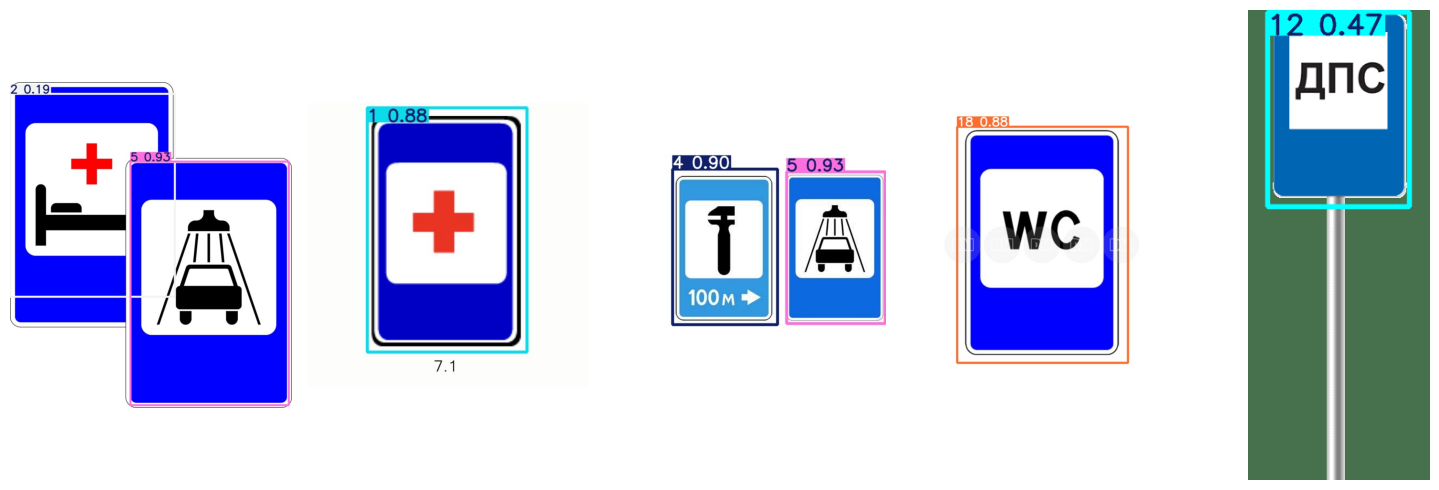

In [ ]:
image_paths = [
    '/content/yolov5/runs/detect/exp4/image_1.jpg',
    '/content/yolov5/runs/detect/exp4/image_2.jpg',
    '/content/yolov5/runs/detect/exp4/image_3.jpg',
    '/content/yolov5/runs/detect/exp4/image_4.jpg',
    '/content/yolov5/runs/detect/exp4/image_5.png'
]

n_images = len(image_paths)
fig, axes = plt.subplots(1, n_images, figsize=(15, 5))

for i, image_path in enumerate(image_paths):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**Вывод:** Подход на основе HOG-дескрипторов оказался слишком медленным и малоэффективным, а также было получено значение maP50 равное нулю. Модель YOLO эффективно справилась с детекцией на небольшой валидационной выборке, показав более высокий результат.